In [909]:
"""
This code has five main functions, with options for scaling laws for two of those main functions. These functions
    were modified from the Meloch Fortran code (https://www.eaps.purdue.edu/impactcrater/)
1: From impactor size, find crater diameter. Choose between Pi scaling (prefered), Yield, Gault, and 
    de Pater and Lissauer scaling laws.
2: From crater diameter, find impactor size. Specify c_d as the final diameter, and f2t() will automatically
    convert into transient crater diameter for the sake of the scale law. Choose between Pi scaling (prefered),
    Yield, Gault, and de Pater and Lissauer scaling laws.
3: Convert from transient crater diameter to final crater diameter, and identify the crater type 
    (Simple, Complex, Simple/Complex, or Peak-Ring).
4: Convert from final crater diameter to transient crater diameter. 
5: Convert directly from final crater diameter to impactor diameter using equations from Johnson et al. 2016.
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.interpolate import interp1d as interp

"""
First set of functions: from impactor size, calculate transient crater diameter.
"""

grav = 1.62 #m s^-2, gravitational acceleration for the Moon
t_rho = 1500. #kg m^-3, highlands regolith, Carrier et al. 1991
i_rho = 1300. #kg m^-2, consistent with an ordinary chondrule meteorite, update with distribution
i_d = 3000. #m, update if known
velocity = 20000. #20000 m/s, or 20 km/s, average impacting velocity, update with distribution

theta = 45 #average impact angle
c_d = 100000. #m, update if known

def Ek(i_rho, i_d, velocity):
    return 0.5 * i_rho * (4./3.)*np.pi*((0.5*i_d)**3) * velocity**2

def dePaterLissauer(i_rho, t_rho, grav, i_d, Ek, theta):
    c_d = 1.8*(i_rho**0.11)*(t_rho**-0.33)*(grav**-0.22)*(i_d**0.13)*(Ek**0.22)*(np.sin(np.deg2rad(theta))**0.33)
    return c_d

def Gault(i_rho, t_rho, grav, i_d, Ek, theta):
    anglefac=np.sin(np.deg2rad(theta))**0.33
    densfac=(i_rho**0.16667)/np.sqrt(t_rho)
    m=(np.pi/6.)*i_rho*(i_d**3)
    W=0.5*m*velocity**2
    #gsmall=0.25*densfac*(W**0.29)*anglefac #for loose sand and liquid target materials
    gsmall=0.015*densfac*(W**0.37)*anglefac**2
    if gsmall < 100:
        Dgault=gsmall
    else:
        Dgault=0.27*densfac*(W**0.28)*anglefac   
    Dgault=Dgault*(1.62/grav)**0.165
    c_d = Dgault 
    return c_d

def Yield(i_rho, t_rho, grav, i_d, Ek, theta):
    anglefac=np.sin(np.deg2rad(theta))**0.33
    densfac=(i_rho**0.16667)/np.sqrt(t_rho)
    pifac=(1.61*grav)/velocity**2
    pitwo=pifac*i_d
    m=(np.pi/6.)*i_rho*(i_d**3)
    W=0.5*m*velocity**2
    dscale=(m/t_rho)**0.33
    Cd = 1.6 #1.88,1.54 ,1.6 /
    beta = 0.22 #0.22,0.165,0.22/
    Dyield=0.0133*W**(1/3.4)+1.51*np.sqrt(i_rho/t_rho)*i_d
    Dyield=Dyield*anglefac*(9.8/grav)**0.165
    c_d = Dyield
    return c_d

def PiScale(i_rho, t_rho, grav, i_d, Ek, velocity, theta):
    anglefac=np.sin(np.deg2rad(theta))**0.33
    densfac=(i_rho**0.16667)/np.sqrt(t_rho)
    pifac=(1.61*grav)/velocity**2
    pitwo=pifac*i_d
    m=(np.pi/6.)*i_rho*(i_d**3)
    W=0.5*m*velocity**2
    dscale=(m/t_rho)**0.33
    Cd = 1.6 #1.88,1.54 ,1.6 /
    beta = 0.22 #0.22,0.165,0.22/
    Dpiscale=dscale*Cd*pitwo**(-beta)
    Dpiscale=Dpiscale*anglefac
    c_d = Dpiscale
    return c_d

def Collins(i_rho, t_rho, grav, i_d, velocity, theta):
    c_d = 1.161*((i_rho/t_rho)**0.33)*(i_d**0.78)*(velocity**0.44)*(grav**-0.22)*(np.sin(np.deg2rad(theta)))**0.33
    return c_d

def Prieur(i_rho, t_rho, grav, i_d, velocity, theta):
    Dsg = 2000. #UPDATE
    Y0 = Dsg/5.3
    eff = 0. #20.9*Y0 #UPDATE, effective strength of target material
    mu = 0.44#(2.*beta)/(1. − beta) #UPDATE, velocity scaling exponent
    nu = 0.4 #density scaling exponent
    K1 = 1. #UPDATE
    Kd = 1.6 #scaling coefficient, Prieur et al. 2017
    beta = -.170 #mu/(2. + mu) #Prieur et al. 2017
    pi2 = 1.61*(grav*i_d)/(velocity**2)
    pi3 = eff/(i_rho*(velocity**2))
    pi4 = i_rho/t_rho
    piD = 1.6*pi2**-0.22
#K1 * ((pi2*pi4)**((2.+mu-(6*nu)/(-3.*mu))) + (pi3*pi4)**((2.-(6.*nu))/(-3.*mu))**((2+mu)/(2)))**(-beta) #Kd*(pi2**(-beta))#
    c_d = piD / ((t_rho)/(i_rho*(4./3.)*np.pi*((i_d/2.)**(3))))**0.33 
    return c_d

def Potter(i_rho, t_rho, grav, i_d, velocity, theta):
    pi2 = 3.22*(grav*(i_d/2.0))/(velocity**2)
    piD=1.6*pi2**-0.22
    c_d=piD *((i_rho*(4./3.)*np.pi*((i_d/2.)**(3)))/(t_rho))**0.33
    return c_d

In [910]:
"""
Second set of functions: from transient crater diameter, find impactor size. (Use f2t() in command line to 
    convert from final crater diameter to transient crater diameter.)
"""

def dePaterLissauer_back(i_rho, t_rho, grav, Dt, Ek, vel, theta):
    i_d = (c_d / (1.8*(i_rho**0.11)*(t_rho**-0.33)*(grav**-0.22)*(Ek**0.22)*(np.sin(np.deg2rad(theta))**0.33)))**(1./0.13)
    return i_d

def Gault_back(i_rho, t_rho, grav, Dt, vel, theta):
    anglefac=np.sin(np.deg2rad(theta))**0.33
    densfac=(i_rho**0.16667)/np.sqrt(t_rho)
    Dstd=Dt*(grav/1.62)**0.165
    if (Dstd <= 10.):
        W=((Dstd/0.015)/(densfac*anglefac**2))**2.70
    elif (Dstd < 300.):
        W=((Dstd/0.25)/(densfac*anglefac))**3.45
    else:
        W=((Dstd/0.27)/(densfac*anglefac))**3.57
    i_d =((12.*W)/(np.pi*i_rho*vel**2))**0.33
    return i_d

def Yield_back(i_rho, t_rho, grav, Dt, vel, theta):
    anglefac=np.sin(np.deg2rad(theta))**0.33
    Dstd=(Dt*(grav/9.8)**0.165)/anglefac
    W=(Dstd/0.0133)**3.4
    i_d=((12.*W)/(np.pi*i_rho*vel**2))**0.33
    return i_d

def Pi_back(i_rho, t_rho, grav, Dt, vel, theta):
    dscale=((6.*t_rho)/(np.pi*i_rho))**0.33
    anglefac=np.sin(np.deg2rad(theta))**0.33
    pifac=(1.61*grav)/velocity**2
    Cd = 1.6 #1.88,1.54 ,1.6 /
    beta = 0.22 #0.22,0.165,0.22/
    Dstd=Dt/anglefac
    Lpiscale=(Dstd*dscale*pifac**beta)/Cd
    i_d=Lpiscale**(1./(1.-beta))
    return i_d

def Collins_back(i_rho, t_rho, grav, Dt, velocity, theta):
    i_d = (Dt / (1.161*((i_rho/t_rho)**0.33)*(velocity**0.44)*(grav**-0.22)*(np.sin(np.deg2rad(theta)))**0.33) )**(1/0.78)
    return i_d

def Prieur_back(i_rho, t_rho, grav, Dt, velocity, theta):
    Kd = 1.6 #scaling coefficient, Prieur et al. 2017
    K1 = 1. #UPDATE
    mu = 0.44
    beta = mu/(2. + mu) #-.170 #Prieur et al. 2017
    #pi2 = 1.61*(grav*i_d)/(velocity**2)
    #pi3 = eff/(i_rho*(velocity**2))
    #pi4 = i_rho/t_rho
    #piD = Kd*(pi2**(-beta))
    #print((2.*Dt)/Kd,((grav*1.61)**(-beta)),(1./(velocity**(-2./beta))),(((4./3.)*np.pi)**3), (1./(9.-beta)))
    i_d = ((((2.**9.)*Dt)/Kd) * ((grav*1.61)**(1./-0.22))* (velocity**(2./-0.22)) * (t_rho**0.33) * ((i_rho*np.pi*(4./3.))**3.) )**(1./(9.-0.22))
    #((((2.**3)*Dt)/Kd) * ((grav*1.61)**(1./-beta)) * (velocity**(2./-beta)) * (i_rho*(4./3.)*np.pi)**0.33) ** (1./(9.-beta))
    return i_d

def Potter_back(i_rho, t_rho, grav, Dt, velocity, theta):
    i_d = ((8.*t_rho*(Dt**3.)) / ((1.6**-0.22)*(np.pi*(4./3.)*i_rho)*((1.6*grav)/(velocity**2.)))) ** (3.-0.66)
    return i_d

In [911]:
"""
Third set of functions: convert from transient crater diameter to final crater diameter, and identify crater type.
"""

def t2f_Meloch(c_d, grav=1.62, t_rho=3000.):
    gama = 1.25
    eta = 0.13
    Dstar=(1.62*2700.*1.8e4)/(grav*t_rho) #transition crater diameter 
    Dpr=(1.62*2700.*1.4e5)/(grav*t_rho) #peak crater diameter
    Dsimple=gama*c_d
    if (Dsimple >= Dstar):
        Dfinal=Dsimple
        cratertype='Simple'
    else:
        Dfinal=Dsimple*(Dsimple/Dstar)**eta
        cratertype='Complex'
    if((Dsimple < Dstar*1.4) and (Dsimple > Dstar*0.71)):
        cratertype='Simple/Complex'
    if(Dfinal > Dpr):
        cratertype='Peak-ring'
    return Dfinal#, cratertype

def t2f_SandM(c_d, grav=1.62, t_rho=3000.):
    gama = 1.5
    eta = 0.13
    Dstar=(1.62*2700.*1.8e4)/(grav*t_rho) #transition crater diameter 
    Dpr=(1.62*2700.*1.4e5)/(grav*t_rho) #peak crater diameter
    Dsimple=gama*c_d
    if (Dsimple >= Dstar):
        Dfinal=Dsimple
        cratertype='Simple'
    else:
        Dfinal=Dsimple*(Dsimple/Dstar)**eta
        cratertype='Complex'
    if((Dsimple < Dstar*1.4) and (Dsimple > Dstar*0.71)):
        cratertype='Simple/Complex'
    if(Dfinal > Dpr):
        cratertype='Peak-ring'
    return Dfinal#, cratertype

def t2f_Holsapple(c_d, grav=1.62, t_rho=3000.):
    gama = 1.32
    eta = 0.089
    Dstar=(1.62*2700.*1.8e4)/(grav*t_rho) #transition crater diameter 
    Dpr=(1.62*2700.*1.4e5)/(grav*t_rho) #peak crater diameter
    Dsimple=gama*c_d
    if (Dsimple >= Dstar):
        Dfinal=Dsimple
        cratertype='Simple'
    else:
        Dfinal=Dsimple*(Dsimple/Dstar)**eta
        cratertype='Complex'
    if((Dsimple < Dstar*1.4) and (Dsimple > Dstar*0.71)):
        cratertype='Simple/Complex'
    if(Dfinal > Dpr):
        cratertype='Peak-ring'
    return Dfinal#, cratertype

In [912]:
"""
Fourth set of functions: Convert from final crater diameter to transient crater diameter.
"""

def f2t(Dfinal, grav=1.62, t_rho=3000.):
    gama = 1.25
    eta = 0.13
    Dstar=(1.62*2700.*1.8e4)/(grav*t_rho) #transition crater diameter 
    Dpr=(1.62*2700.*1.4e5)/(grav*t_rho) #peak crater diameter
    if (Dfinal <= Dstar):
        Dt=Dfinal/gama
    else:
        Dt=(1./gama)*(Dfinal*Dstar**eta)**(1./(1.+eta))
    return Dt

In [913]:
"""
Fifth set of functions: Convert direction from final crater diameter to impactor diameter (Johnson 2016)
"""

def simple2complex_diam(gravity, density, s2c_moon=18e3, 
                        g_moon=1.62, rho_moon=2700.):
    """
    Return simple to complex transition diameter given gravity of body [m s^-2] 
    and density of target [kg m^-3] (Melosh 1989). 
    """
    return g_moon * rho_moon * s2c_moon / (gravity * density)

def Johnson(i_rho, t_rho, grav, i_d, vel, theta):
    Dstar=(1.62*2700.*1.8e4)/(grav*t_rho)
    c_d = 1.52*((i_rho/t_rho)**0.38)*(i_d**0.88)*(vel**0.5)*(grav**-0.25)*(Dstar**-0.13)*(np.sin(np.deg2rad(theta))**0.38)
    return c_d

def Johnson_back(rho_i, rho_t, g, t_diam, v, theta):#i_rho, t_rho, grav, f_d, vel, theta):
    #Dstar=(1.62*2700.*1.8e4)/(grav*t_rho)
    #i_d = (f_d / (1.52*((i_rho/t_rho)**0.38)*(vel**0.5)*(grav**-0.25)*(Dstar**-0.13)*(np.sin(np.deg2rad(theta))**0.38)))**(1./0.88)
    #return i_d

    trad = np.sin(np.deg2rad(theta))
    ds2c = simple2complex_diam(g, 2700.)
    denom = (1.52 * ((rho_i / rho_t)**0.38) * (v**0.5) * (g**-0.25) * (ds2c**-0.13) * (trad**0.38))
    impactor_length = (t_diam / denom)**(1. / 0.88)
    return impactor_length

In [914]:
"""
Run the code: Given an impactor diameter i_d (your input), calculate the transient crater diameter.
    Currently running all three scaling laws, excluding de Pater and Lissauer, for comparison.
"""
i_d = np.linspace(1, 100000, 5000) #1000.
c_d_g = np.empty(5000)#1000.
c_d_y = np.empty(5000)#1000.
c_d_pi = np.empty(5000)#1000.
c_d_j = np.empty(5000)#1000.
c_d_c = np.empty(5000)#1000.
c_d_p = np.empty(5000)#1000.
c_d_po = np.empty(5000)#1000.

#c_d = dePaterLissauer(i_rho, t_rho, grav, i_d, Ek(i_rho, i_d, velocity), theta)
#print(f'dePater and Lissauer crater diameter is {c_d:.0f} meters, {c_d/1000:.1f} kilometers for a {i_d/1000:.1f} kilometer impactor')
for i in range(0,5000):
    c_d_g[i] = t2f_Holsapple(Gault(i_rho, t_rho, grav, i_d[i], Ek(i_rho, i_d[i], velocity), theta))
    #print(f'Gault crater diameter is {c_d:.0f} meters, {c_d/1000:.1f} kilometers for a {i_d/1000:.1f} kilometer impactor')

    c_d_y[i] = t2f_Holsapple(Yield(i_rho, t_rho, grav, i_d[i], Ek(i_rho, i_d[i], velocity), theta))
    #print(f'Yield crater diameter is {c_d:.0f} meters, {c_d/1000:.1f} kilometers for a {i_d/1000:.1f} kilometer impactor')
    
    c_d_pi[i] = t2f_Holsapple(PiScale(i_rho, t_rho, grav, i_d[i], Ek(i_rho, i_d[i], velocity), velocity, theta))
    #print(f'Pi crater diameter is {c_d:.0f} meters, {c_d/1000:.1f} kilometers for a {i_d/1000:.1f} kilometer impactor')
    
    c_d_j[i] = Johnson(i_rho, t_rho, grav, i_d[i], velocity, theta)
        
    c_d_j[i] = t2f_Holsapple(Collins(i_rho, t_rho, grav, i_d[i], velocity, theta))

    c_d_p[i] = t2f_Holsapple(Prieur(i_rho, t_rho, grav, i_d[i], velocity, theta))
    #print(f'Prieur crater diameter is {c_d_p[i]:.0f} meters, {c_d_p[i]/1000:.1f} kilometers for a {i_d[i]/1000:.1f} kilometer impactor')
    
    c_d_po[i] = t2f_Holsapple(Potter(i_rho, t_rho, grav, i_d[i], velocity, theta))

#print(f'Pi crater diameter is {c_d:.0f} meters, {c_d/1000:.1f} kilometers for a {i_d/1000:.1f} kilometer impactor')

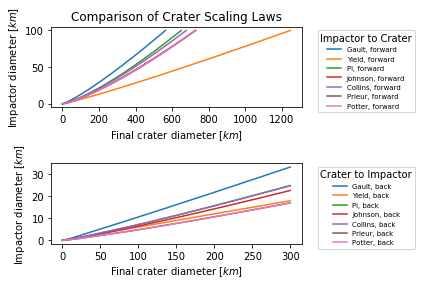

In [915]:
"""
Run the code: Given a final crater diameter c_d (your input), calculate the impactor diameter.
    Currently running all three scaling laws, excluding de Pater and Lissauer, for comparison.
"""

c_d = np.linspace(1, 300000, 5000)#100000. 
i_d_g = np.empty(5000)#1000.
i_d_y = np.empty(5000)#1000.
i_d_pi = np.empty(5000)#1000.
i_d_j = np.empty(5000)#1000.
i_d_c = np.empty(5000)#1000.
i_d_p = np.empty(5000)#1000.
i_d_po = np.empty(5000)#1000.

#i_d = dePaterLissauer_back(i_rho, t_rho, grav, f2t(c_d,grav,t_rho), Ek(i_rho, i_d, velocity), velocity, theta)
#print(f'dePater and Lissauer impactor diameter is {i_d:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')
for i in range(0,5000):
    i_d_g[i] = Gault_back(i_rho, t_rho, grav, f2t(c_d[i],grav,t_rho), velocity, theta)
    #print(f'Gault impactor diameter is {i_d_g:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')

    i_d_y[i] = Yield_back(i_rho, t_rho, grav, f2t(c_d[i],grav,t_rho), velocity, theta)
    #print(f'Yield impactor diameter is {i_d_y:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')

    i_d_pi[i] = Pi_back(i_rho, t_rho, grav, f2t(c_d[i],grav,t_rho), velocity, theta)
    #print(f'Pi impactor diameter is {i_d_pi:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')

    i_d_j[i] = Johnson_back(i_rho, t_rho, grav, c_d[i], velocity, theta)
    #print(f'Johnson impactor diameter is {i_d_j:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')
    
    i_d_c[i] = Collins_back(i_rho, t_rho, grav, f2t(c_d[i],grav,t_rho), velocity, theta) #f2t(c_d[i],grav,t_rho)
    #print(f'Collins impactor diameter is {i_d_c:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')

    Prieur_int = interp(c_d_p, i_d, fill_value="extrapolate")
    i_d_p[i] = Prieur_int(f2t(c_d[i],grav,t_rho))
    #Prieur_back(i_rho, t_rho, grav, f2t(c_d[i],grav,t_rho), velocity, theta)
    #print(f'Prieur impactor diameter is {i_d_p:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')
    
    Potter_int = interp(c_d_po, i_d, fill_value="extrapolate")
    i_d_po[i] = Potter_int(f2t(c_d[i],grav,t_rho))    
    #i_d_po[i] = Potter_back(i_rho, t_rho, grav, f2t(c_d[i],grav,t_rho), velocity, theta)
    #print(f'Potter impactor diameter is {i_d_p:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')

f, axes = plt.subplots(2)#, figsize=(5,5))
axes[0].plot(c_d_g/1000, i_d/1000, label='Gault, forward')
axes[0].plot(c_d_y/1000, i_d/1000, label='Yield, forward')
axes[0].plot(c_d_pi/1000, i_d/1000, label='Pi, forward')
axes[0].plot(c_d_j/1000, i_d/1000, label='Johnson, forward')
axes[0].plot(c_d_c/1000, i_d/1000, label='Collins, forward')
axes[0].plot(c_d_p/1000, i_d/1000, label='Prieur, forward')
axes[0].plot(c_d_po/1000, i_d/1000, label='Potter, forward')
axes[0].set_xlabel('Final crater diameter [$km$]')
axes[0].set_ylabel('Impactor diameter [$km$]')
axes[0].legend(title='Impactor to Crater', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
axes[0].set_title('Comparison of Crater Scaling Laws')
axes[1].plot(c_d/1000, i_d_g/1000, label='Gault, back')
axes[1].plot(c_d/1000, i_d_y/1000, label='Yield, back')
axes[1].plot(c_d/1000, i_d_pi/1000, label='Pi, back')
axes[1].plot(c_d/1000, i_d_j/1000, label='Johnson, back')
axes[1].plot(c_d/1000, i_d_c/1000, label='Collins, back')
axes[1].plot(c_d/1000, i_d_p/1000, label='Prieur, back')
axes[1].plot(c_d/1000, i_d_po/1000, label='Potter, back')
axes[1].set_xlabel('Final crater diameter [$km$]')
axes[1].set_ylabel('Impactor diameter [$km$]')
axes[1].legend(title='Crater to Impactor', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')
plt.tight_layout(True)
plt.savefig('Crater_scaling.png', dpi=300)

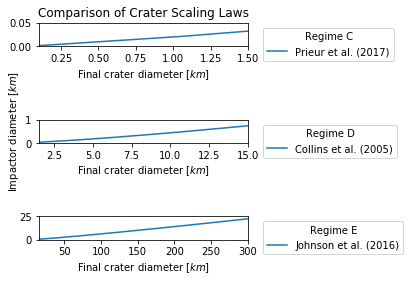

In [916]:
f2, axes = plt.subplots(3)#, figsize=(5,5))
#axes[0].plot(c_d_g/1000, i_d/1000, label='Gault, forward')
#axes[0].plot(c_d_y/1000, i_d/1000, label='Yield, forward')
#axes[0].plot(c_d_pi/1000, i_d/1000, label='Pi, forward')
#axes[0].plot(c_d_j/1000, i_d/1000, label='Johnson, forward')
#axes[0].plot(c_d_c/1000, i_d/1000, label='Collins, forward')
axes[0].plot(c_d/1000, i_d_p/1000, label='Prieur et al. (2017)')
#axes[0].plot(c_d_po/1000, i_d/1000, label='Potter, forward')
axes[0].set_xlim(0.1,1.5)
axes[0].set_ylim(0,0.05)
axes[0].set_xlabel('Final crater diameter [$km$]')
#axes[0].set_ylabel('Impactor diameter [$km$]')
axes[0].legend(title='Regime C', bbox_to_anchor=(1.05, 1), loc='upper left')#, fontsize='small') #
axes[0].set_title('Comparison of Crater Scaling Laws')
#axes[1].plot(c_d/1000, i_d_g/1000, label='Gault, back')
#axes[1].plot(c_d/1000, i_d_y/1000, label='Yield, back')
#axes[1].plot(c_d/1000, i_d_pi/1000, label='Pi, back')
#axes[1].plot(c_d/1000, i_d_j/1000, label='Johnson, back')
axes[1].plot(c_d/1000, i_d_c/1000, label='Collins et al. (2005)')
#axes[1].plot(c_d/1000, i_d_p/1000, label='Prieur, back')
#axes[1].plot(c_d/1000, i_d_po/1000, label='Potter, back')
axes[1].set_xlim(1.5,15)
axes[1].set_ylim(0,1)
axes[1].set_xlabel('Final crater diameter [$km$]')
axes[1].set_ylabel('Impactor diameter [$km$]')
axes[1].legend(title='Regime D', bbox_to_anchor=(1.05, 1), loc='upper left')#, fontsize='x-small')
#axes[2].plot(c_d/1000, i_d_g/1000, label='Gault, back')
#axes[2].plot(c_d/1000, i_d_y/1000, label='Yield, back')
#axes[2].plot(c_d/1000, i_d_pi/1000, label='Pi, back')
axes[2].plot(c_d/1000, i_d_j/1000, label='Johnson et al. (2016)')
#axes[2].plot(c_d/1000, i_d_c/1000, label='Collins, back')
#axes[2].plot(c_d/1000, i_d_p/1000, label='Prieur, back')
#axes[2].plot(c_d/1000, i_d_po/1000, label='Potter, back')
axes[2].set_xlim(15,300)
axes[2].set_ylim(0,25)
axes[2].set_xlabel('Final crater diameter [$km$]')
#axes[2].set_ylabel('Impactor diameter [$km$]')
axes[2].legend(title='Regime E', bbox_to_anchor=(1.05, 1), loc='upper left')#, fontsize='x-small')
plt.tight_layout(True)
plt.savefig('Crater_scaling_regimes.png', dpi=300)

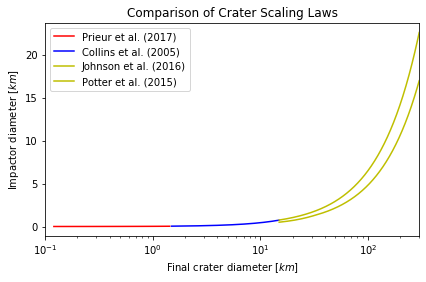

In [917]:
plt.semilogx(c_d[(100<=c_d) & (c_d<=1500)]/1000, i_d_p[(100<=c_d) & (c_d<=1500)]/1000, 'r-', label='Prieur et al. (2017)')
#print(c_d[c_d>=100]/1000, i_d_p[i,c_d[i]>=100]/1000)
plt.semilogx(c_d[(1500<=c_d) & (c_d<=15000)]/1000, i_d_c[(1500<=c_d) & (c_d<=15000)]/1000, 'b-', label='Collins et al. (2005)')
plt.semilogx(c_d[(15000<=c_d) & (c_d<=300000)]/1000, i_d_j[(15000<=c_d) & (c_d<=300000)]/1000, 'y-', label='Johnson et al. (2016)')
plt.semilogx(c_d[(15000<=c_d) & (c_d<=300000)]/1000, i_d_p[(15000<=c_d) & (c_d<=300000)]/1000, 'y--', label='Potter et al. (2015)')
plt.xlim(0.1, 300)
plt.xlabel('Final crater diameter [$km$]')
plt.ylabel('Impactor diameter [$km$]')
plt.title('Comparison of Crater Scaling Laws')
plt.legend()#title='Regime E', bbox_to_anchor=(1.05, 1), loc='upper left')#, fontsize='x-small')
plt.tight_layout(True)
plt.savefig('Crater_scaling_regimes2.png', dpi=300)#[i,ke[i,:] >= 10**9.5]

In [918]:
"""
Run the code: For the Pi scaling law, find the crater diameter given a 1km impactor and the impactor diameter 
    given a 100km crater. Used to compare to online tool here: https://www.eaps.purdue.edu/impactcrater/
"""

i_d = 1000. #1 km

c_d = PiScale(i_rho, t_rho, grav, i_d, Ek(i_rho, i_d, velocity), velocity, theta)
print(f'Pi crater diameter is {c_d:.0f} meters, {c_d/1000:.1f} kilometers for a {i_d/1000:.1f} kilometer impactor')

c_d = 100000. #100 km

i_d = Pi_back(i_rho, t_rho, grav, f2t(c_d,grav,t_rho), velocity, theta)
print(f'Pi impactor diameter is {i_d:.0f} meters, {i_d/1000:.1f} kilometers for a {c_d/1000:.1f} kilometer crater')

df, ctype = t2f(c_d, grav, t_rho)
print(f'Final crater diameter is {df/1000:.1f} kilometers, and it is a {ctype} crater')

Pi crater diameter is 14193 meters, 14.2 kilometers for a 1.0 kilometer impactor
Pi impactor diameter is 7115 meters, 7.1 kilometers for a 100.0 kilometer crater
Final crater diameter is 125.0 kilometers, and it is a Simple crater


Text(0.5, 0, 'Final Diameter (km)')

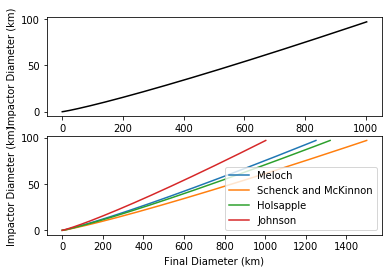

In [919]:
c_d = np.linspace(10, 1000000, 5000)
i_d = np.empty(5000)
f_d_m = np.empty(5000)
f_d_sm = np.empty(5000)
f_d_h = np.empty(5000)
f_d_j = np.empty(5000)
fig, ax = plt.subplots(2)
for i in range(0,5000):
    i_d[i] = Pi_back(i_rho, t_rho, grav, f2t(c_d[i],grav,t_rho), velocity, theta)
    f_d_m[i] = t2f_Meloch(c_d[i]) #, ctype
    f_d_sm[i] = t2f_SandM(c_d[i]) #, ctype
    f_d_h[i] = t2f_Holsapple(c_d[i]) #, ctype
    f_d_j[i] = Johnson(i_rho, t_rho, grav, i_d[i], velocity, theta)
ax[0].plot(f_d_j/1000, i_d/1000, 'k-')
ax[0].set_xlabel('Crater Diameter (km)')
ax[0].set_ylabel('Impactor Diameter (km)')

ax[1].plot(f_d_m/1000, i_d/1000, label="Meloch")
ax[1].plot(f_d_sm/1000, i_d/1000, label="Schenck and McKinnon")
ax[1].plot(f_d_h/1000, i_d/1000, label="Holsapple")
ax[1].plot(f_d_j/1000, i_d/1000, label="Johnson")
ax[1].legend()
ax[1].set_ylabel('Impactor Diameter (km)')
ax[1].set_xlabel('Final Diameter (km)')

In [920]:
print(Collins_back(i_rho, t_rho, grav, 1200, velocity, theta))

38.67183060126055
